Tradify: Multi-Class Classification Jajanan dan Masakan khas Indonesia menggunakan Transfer Learning (VGG19)

Import library yang dibutuhkan

cutmix = augmentasi data
zipfile & os = keperluan direktori
tensorflow = pembuatan model

In [1]:
from cutmix_keras import CutMixImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import tensorflow as tf

Unzip dataset

In [2]:
local_zip = 'jajanan_indonesia_final.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('./')
zip_ref.close()

In [3]:
base_dir = './jajanan_indonesia_final'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

Melihat data yang terdapat di dalam direktori training

Found 678 files belonging to 8 classes.


2022-06-05 15:43:30.102860: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-05 15:43:30.103120: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


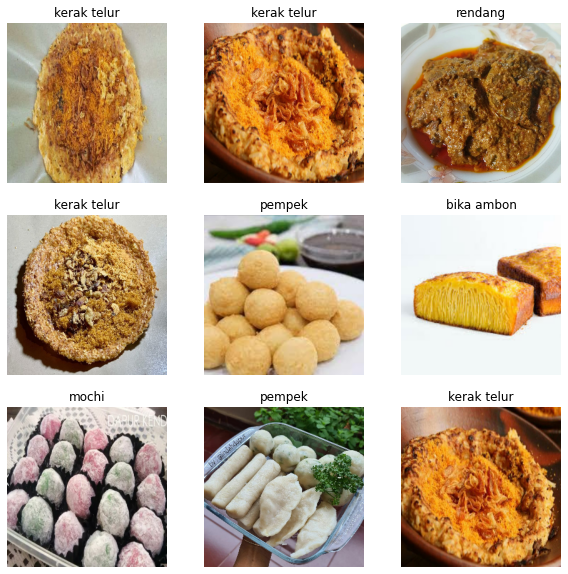

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True)

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Praproses: 

- data augmentation menggunakan imagedatagenerator keras serta cutmix generator
- shuffling training images
- rescale images

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 64

def train_val_generators(dir_train, dir_validation, dir_test):
    train_datagen = ImageDataGenerator(rescale = 1./255.,
                                       rotation_range=40,
                                       width_shift_range=.2,
                                       height_shift_range=.2,
                                       shear_range=.2,
                                       zoom_range=.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')
    
    train_generator1 = train_datagen.flow_from_directory(dir_train, batch_size=16, 
                                                        class_mode = 'categorical', 
                                                        seed=100, shuffle=True,
                                                        target_size=(64, 64))
    train_generator2 = train_datagen.flow_from_directory(dir_train, batch_size=16, 
                                                        class_mode = 'categorical', 
                                                        seed=100, shuffle=True,
                                                        target_size=(64, 64))
    train_generator = CutMixImageDataGenerator(
    generator1=train_generator1,
    generator2=train_generator2,
    img_size=IMG_SIZE,
    batch_size=16)
    
    validation_datagen = ImageDataGenerator(rescale = 1./255.)
    validation_generator = validation_datagen.flow_from_directory(dir_validation, batch_size=16,
                                                                  class_mode = 'categorical', 
                                                                  seed=100, target_size=(64, 64))
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_generator = test_datagen.flow_from_directory(dir_test, batch_size=16,
                                                      class_mode='categorical', 
                                                      seed=100, target_size=(64, 64))
    
    return train_generator, validation_generator, test_generator

In [6]:
train_generator, validation_generator, test_generator = train_val_generators(train_dir, validation_dir, test_dir)

Found 678 images belonging to 8 classes.
Found 678 images belonging to 8 classes.
Found 155 images belonging to 8 classes.
Found 138 images belonging to 8 classes.


Penggunaan pre-trained model, yakni VGG19. 

dipilih karena memiliki arsitektur yang mirip dengan model tradify sebelumnya.

weight berasal dari imagenet

In [7]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers
from tensorflow.keras import Model

base_model = VGG19(weights='imagenet', input_shape=(64, 64, 3), include_top=False)
base_model.trainable = False

In [8]:
last = base_model.get_layer('block4_pool').output

Penambahan hidden layer serta dropout.

Softmax digunakan karena memiliki akurasi yang bagus untuk kasus multi-class

In [9]:
x = layers.Flatten()(last)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.1)(x)                  
x = layers.Dense(8, activation='softmax')(x)

In [10]:
from tensorflow.keras.optimizers import RMSprop, Adam

model = Model(inputs= base_model.input,outputs= x) 
model.compile(optimizer = Adam(lr=0.0001),
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training model sebanyak 20 epochs

In [11]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 20,
            steps_per_epoch = 64,
            verbose = 1)

Epoch 1/20



User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   OMP_NUM_THREADS=4

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'

 1/64 [..............................] - ETA: 53s - loss: 10.0582 - accuracy: 0.1250

OMP: Info #249: KMP_AFFINITY: pid 19885 tid 19916 thread 4 bound to OS proc set 0
OMP: Info #249: KMP_AFFINITY: pid 19885 tid 19967 thread 5 bound to OS proc set 1
OMP: Info #249: KMP_AFFINITY: pid 19885 tid 19968 thread 6 bound to OS proc set 2
OMP: Info #249: KMP_AFFINITY: pid 19885 tid 19969 thread 7 bound to OS proc set 3


64/64 [==============================] - 29s 454ms/step - loss: 6.4297 - accuracy: 0.4241 - val_loss: 2.1091 - val_accuracy: 0.6774
Epoch 2/20
64/64 [==============================] - 28s 441ms/step - loss: 2.5610 - accuracy: 0.6282 - val_loss: 2.7631 - val_accuracy: 0.6387
Epoch 3/20
64/64 [==============================] - 28s 447ms/step - loss: 1.6340 - accuracy: 0.7102 - val_loss: 1.0404 - val_accuracy: 0.7871
Epoch 4/20
64/64 [==============================] - 28s 440ms/step - loss: 1.2463 - accuracy: 0.7594 - val_loss: 1.0015 - val_accuracy: 0.7935
Epoch 5/20
64/64 [==============================] - 27s 429ms/step - loss: 1.0845 - accuracy: 0.7709 - val_loss: 1.1785 - val_accuracy: 0.7806
Epoch 6/20
64/64 [==============================] - 29s 460ms/step - loss: 0.8458 - accuracy: 0.7949 - val_loss: 0.9966 - val_accuracy: 0.7742
Epoch 7/20
64/64 [==============================] - 27s 430ms/step - loss: 0.8177 - accuracy: 0.8058 - val_loss: 0.7237 - val_accuracy: 0.8258
Epoch 8/20

Evaluasi model menggunakan data test

In [12]:
results = model.evaluate(test_generator)

9/9 [==============================] - 2s 242ms/step - loss: 0.7802 - accuracy: 0.8623


Grafik akurasi training & validation data

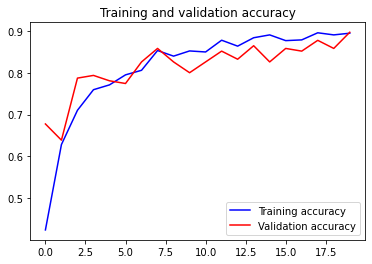

<Figure size 432x288 with 0 Axes>

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

Grafik nilai loss training & validation data

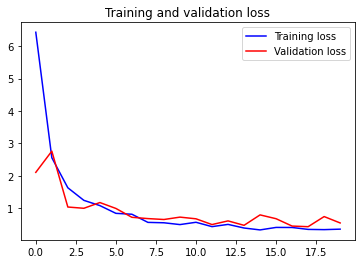

<Figure size 432x288 with 0 Axes>

In [47]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

Convert Model to TFLite

In [39]:
model_dir = './model'
export_dir = os.path.join(model_dir, 'saved_model')
tf.saved_model.save(model,export_dir=export_dir)

INFO:tensorflow:Assets written to: ./model/saved_model/assets


INFO:tensorflow:Assets written to: ./model/saved_model/assets


In [40]:
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [41]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

converter.optimizations = [optimization]

tflite_model = converter.convert();

2022-06-05 16:48:52.669078: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-06-05 16:48:52.669117: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-06-05 16:48:52.669398: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: ./model/saved_model
2022-06-05 16:48:52.672758: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-06-05 16:48:52.672791: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: ./model/saved_model
2022-06-05 16:48:52.681338: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-06-05 16:48:52.787468: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: ./model/saved_model
2022-06-05 16:48:52.813386: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Too

In [42]:
import pathlib

tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

14873792

Saving and reloading model in HDF5 file format

In [43]:
from tensorflow.keras.models import load_model
model.save("model.h5")
loaded_model = load_model("model.h5")
loss, accuracy = loaded_model.evaluate(test_generator)

9/9 [==============================] - 2s 236ms/step - loss: 0.7802 - accuracy: 0.8623


In [44]:
pip install tensorflowjs

Note: you may need to restart the kernel to use updated packages.


tensorflowjs_converter to convert the saved Keras model into JSON format.

In [45]:
!tensorflowjs_converter --input_format=keras "./model.h5" ./